<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/hw3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install youtokentome

In [3]:
!pip install alive-progress

In [2]:
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda

In [3]:
# !pip install mxnet-cu92

In [4]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [5]:
print(torch.cuda.device_count())

1


In [6]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [7]:
device = torch.device('cuda:0')

In [8]:
# !pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/My Drive/unsupervised.csv.zip'

In [8]:
!unzip '/content/drive/My Drive/qa_data.jsonl.zip'

Archive:  /content/drive/My Drive/qa_data.jsonl.zip
replace qa_data.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
# questions = pd.read_csv('unsupervised.csv')
# questions.question = questions.question.map(lambda x: x.lower())

qa_data = list()

with open('qa_data.jsonl') as file_object:
    for line in file_object:
        qa_data.append(json.loads(line.strip()))
file_object.close()
qa_data = qa_data[:math.ceil(len(qa_data)*0.4)]#!!!!

In [10]:
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    for que in qa_data:
        f.write(que['question'] + '\n')
f.close()

vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

In [11]:
%%time
# обучаем
# раскомментируйте этот код, чтобы обучить bpe
yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

CPU times: user 10.2 s, sys: 1.08 s, total: 11.2 s
Wall time: 6.88 s


In [12]:
# загружаем токенизатор
tokenizer = yttm.BPE(model=model_path)

In [13]:
qa_data = qa_data[:math.ceil(len(qa_data)*0.6)]

In [57]:
tok_pairs = []
max_length = 32
for i in qa_data:
  
  tok_quest = tokenizer.encode(i['question'], bos=True, eos=True)
  for resp in i['responses']:
    pair = (tok_quest, tokenizer.encode(resp, eos=True))
    # pair.append(tok_quest, tokenizer.encode(resp, bos=True, eos=True))
    tok_pairs.append(pair)


In [58]:
tok_pairs[9]

([2, 572, 13653, 14803, 402, 3978, 392, 10868, 13775, 3],
 [364, 363, 2368, 4915, 434, 364, 438, 425, 15921, 506, 4118, 11565, 3])

In [59]:
qa_data[9]

{'category': 'Стиль, Мода, Звезды',
 'question': 'ну что за мода? не успел глотнуть кофе, уже потянулся за сигаретой!',
 'responses': ['не знаю милый, что за кайф! я сама мало курю, но когда напиюся тогда держись!;)))',
  'переходи на чай.',
  'я такой моды не знаю, потому что не курю',
  'а я вообще не курю и никогда не курила, но все равно не терплю, когда курят во время еды и в помещениях! фу!!!!',
  'скажу одно: курень вред. да и коффе неочень полезно']}

In [60]:
train_border = math.ceil(len(tok_pairs)*0.6)
test_border = math.ceil(len(qa_data)*0.8)

In [120]:
my_train = tok_pairs[:train_border]
my_test = tok_pairs[train_border:]

In [121]:
# train_df = pd.DataFrame(qa_data[:train_border])
# test_df = pd.DataFrame(qa_data[train_border:test_border])
# validation_df = pd.DataFrame(qa_data[test_border: ])

In [122]:
tokenizer.encode('аа памагити пожалст', bos=True, eos=True, output_type=yttm.OutputType.SUBWORD)

['<BOS>', '▁аа', '▁па', 'ма', 'ги', 'ти', '▁пожал', 'ст', '<EOS>']

In [123]:

batch_size = 64

max_len = 32 # это типа с запасом?

pad_index = 0
eos_index = 3

In [124]:
class LanguageModelData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index, eos_index):
        
        self.data = data
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        x = self.data[index][0][:self.max_len]
        y = self.data[index][1][:self.max_len]
        
        pads_x = [self.pad_index] * (self.max_len - len(x))
        pads_y = [self.pad_index] * (self.max_len - len(y))

        x = torch.tensor(x + pads_x).long()
        y = torch.tensor(y + pads_y).long()
        
        return x, y

In [125]:

torch.tensor([2] + [2, 3499, 392, 441, 14, 5232, 7788, 3]).long()

tensor([   2,    2, 3499,  392,  441,   14, 5232, 7788,    3])

In [126]:
# sent = tokenizer.encode('аа памагити пожалст', bos=True, eos=True)
# x = sent[:max_len]

# pads_x = [pad_index] * (max_len - len(x))
# x = torch.tensor([x + pads_x]).long()
# x = x.to(device)
# x
# with torch.no_grad():
#   pred = model(x)
# pred

In [127]:
train_dataset = LanguageModelData(data=train, max_len=max_len, 
                                  pad_index=pad_index, eos_index=eos_index)
validation_dataset = LanguageModelData(data=test, max_len=max_len,
                                       pad_index=pad_index, eos_index=eos_index)

len(train_dataset), len(validation_dataset)

(1119610, 746406)

In [128]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [129]:
for x, y in train_loader:
    break

In [130]:
len(validation_loader.dataset)

746406

In [131]:
x

tensor([[   2, 1678,  389,  ...,    0,    0,    0],
        [   2,  424,  389,  ...,    0,    0,    0],
        [   2,  361,  584,  ...,    0,    0,    0],
        ...,
        [   2,  826, 2191,  ...,    0,    0,    0],
        [   2,  826, 2191,  ...,    0,    0,    0],
        [   2,  826, 2191,  ...,    0,    0,    0]])

In [132]:
y

tensor([[ 3499,   392,   441,  ...,     0,     0,     0],
        [  424,   342,  4823,  ...,     0,     0,     0],
        [ 7534,   336, 19442,  ...,     0,     0,     0],
        ...,
        [  363,  1853,  3011,  ...,     0,     0,     0],
        [24624, 17689,   363,  ...,     0,     0,     0],
        [21124,  5742,  3011,  ...,     0,     0,     0]])

In [134]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [135]:
progress_bar = tqdm(total=len(validation_loader.dataset), desc='Testing')

for x, y in validation_loader:
    progress_bar.update(x.size(0))
progress_bar.close()

Testing: 100%|██████████| 746406/746406 [00:09<00:00, 74771.46it/s]


In [136]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers,
                 padding_idx, dropout=0.35, weight_tying=True):
        
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim, padding_idx=padding_idx)
        
        self.embedding_dropout = SpatialDropout(p=dropout)
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, 
                                  num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.language_model_head = torch.nn.Linear(in_features=model_dim, out_features=vocab_size, bias=False)
        
        # как раз здесь задаем, чтобы веса входящего и выходящего слоя эмбеддингов шарились
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        
        x = self.embedding_dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.language_model_head(x)
        
        return x

In [137]:
embedding_dim = 128
model_dim = 128
num_layers = 2
dropout = 0.35

In [138]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim,
                      model_dim=model_dim, num_layers=num_layers,
                      dropout=dropout, padding_idx=pad_index)
model.to(device)

LanguageModel(
  (embedding_layer): Embedding(30000, 128, padding_idx=0)
  (embedding_dropout): SpatialDropout(p=0.35, inplace=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.35)
  (language_model_head): Linear(in_features=128, out_features=30000, bias=False)
)

In [139]:

# у нас есть тег eos (end of sentence), который есть в каждом тренировочном примере
# мы не будем считать лосс для падов
# вместо этого будем останавливать генерирование моделью в момент, когда она сгенерирует тег eos
# 
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [140]:

# функция для обучения одной эпохи
# почти все как всегда

def train(model, loader, criterion, optimizer, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [141]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 11663/11663 [05:39<00:00, 34.33it/s, loss=7.76, perplexity=2.35e+3]


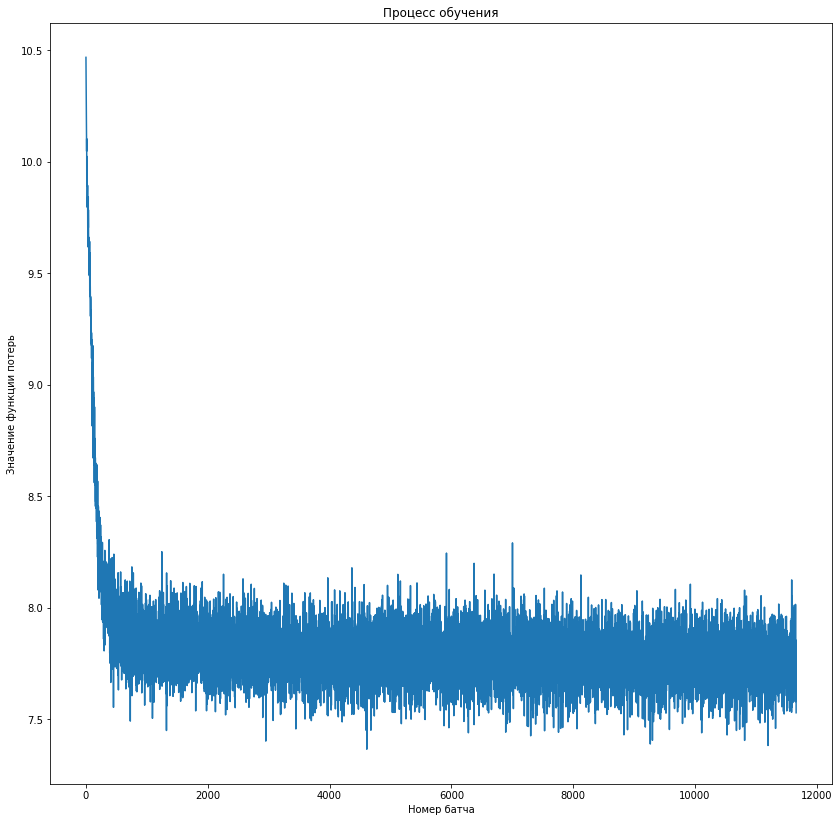

In [142]:

plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(epoch_losses)

In [143]:
def evaluate(model, loader, criterion, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')

    model.eval()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [144]:

val_losses = evaluate(model, validation_loader, criterion)
f'Val loss - {np.mean(val_losses):.3f} perplexity - {np.exp(np.mean(val_losses)):.3f}'

Evaluate: 100%|██████████| 11663/11663 [02:29<00:00, 78.26it/s, loss=7.72, perplexity=2.26e+3]


'Val loss - 7.749 perplexity - 2320.179'

In [48]:
class SpatialDropout(torch.nn.Dropout2d):
    
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.to(device)
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [49]:
spatial_dropout = SpatialDropout()
common_dropout = torch.nn.Dropout()

In [145]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers,
                 padding_idx, dropout=0.35, weight_tying=True):
        
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim, padding_idx=padding_idx)
        
        self.embedding_dropout = SpatialDropout(p=dropout)
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, 
                                  num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.language_model_head = torch.nn.Linear(in_features=model_dim, out_features=vocab_size, bias=False)
        
        # как раз здесь задаем, чтобы веса входящего и выходящего слоя эмбеддингов шарились
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x):

        x = self.embedding_layer(x)
        
        x = self.embedding_dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.language_model_head(x)
        
        return x

In [146]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, dropout=dropout, padding_idx=pad_index, weight_tying=True)

In [147]:
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [148]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 11663/11663 [05:41<00:00, 34.19it/s, loss=7.76, perplexity=2.34e+3]


In [149]:

model.eval()

with torch.no_grad():

    x = x.to(device)
    
    pred = []
    
    zeros = torch.zeros(num_layers, x.size(0), model_dim, dtype=torch.float32, device=x.device)
    hx = (zeros, zeros)
    
    # семплируем начальный токен bos для каждого предложения
    current_token = x[:, 0].unsqueeze(1)
    
    for timestamp in range(x.size(1)):
        
        # пока все то же самое
        emb = model.embedding_layer(current_token)
        

        emb = model.embedding_dropout(emb)

        lstm_out, hx = model.lstm(emb, hx)

        next_token_prediction = model.language_model_head(lstm_out)
        
        pred.append(next_token_prediction)
        
        # но вот здесь мы семплируем предсказания сети и передадим это как текущий токен для следующего таймстемпа
        current_token = next_token_prediction.argmax(dim=2)
        
    pred = torch.cat(pred, dim=1)
    
model.train()
    
tokens = pred.argmax(dim=-1).detach().cpu().numpy()

In [150]:
tokens

array([[364, 363, 363, ...,   3,   3,   3],
       [364, 363, 363, ...,   3,   3,   3],
       [364, 363, 363, ...,   3,   3,   3],
       ...,
       [364, 363, 363, ...,   3,   3,   3],
       [364, 363, 363, ...,   3,   3,   3],
       [364, 363, 363, ...,   3,   3,   3]])

In [151]:
predicted_texts = tokenizer.decode(tokens.tolist())
predicted_texts

['а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EO

In [ ]:
'SequenceBucketingData'

'SequenceBucketingData'

In [ ]:
# сделаем батч побольше
batch_size = 256

batches = []

for i_batch in range(math.ceil(len(qa_data) / batch_size)):
    
    batches.append(qa_data[i_batch*batch_size:(i_batch+1)*batch_size])

In [ ]:
qa_data[0]

{'category': 'Бизнес, Финансы',
 'question': 'долго ли идут деньги с яндексденег на карту visa?',
 'responses': ['нет. прорыв 35 ;)'],
 'tok_answ': [2, 3499, 392, 441, 14, 5232, 7788, 3],
 'tok_quest': [2,
  1678,
  389,
  5459,
  1030,
  325,
  8439,
  23525,
  26,
  342,
  3111,
  7417,
  5752,
  3]}

In [ ]:
class SequenceBucketingData(torch.utils.data.Dataset):
    
    def __init__(self,  data, max_len, pad_index, eos_index):
        
        self.data = data
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def prepare_sample(self, sequence, max_len):
           
      x = sequence[:max_len]
      pads = [self.pad_index] * (self.max_len - len(x))
      # x = torch.tensor(x + pads_x).long()  
      # pads = [self.pad_index] * (max_len - len(x))      
      x += pads        
      return x

    def prepare_target(self, sequence, max_len):
      
      y = sequence[:max_len]        
      pads  = [self.pad_index] * (self.max_len - len(y))
      # y = torch.tensor(y + pads_y).long()  
      # pads = [self.pad_index] * (max_len - len(y))      
      y += pads        
      return y
    
    def __getitem__(self, index):

      batch = self.data[index]
      
      max_len = min([self.max_len, max([len(sample['tok_quest']) for sample in batch])])
      
      batch_x = []
      batch_y = []
      
      for sample in batch:

          x = self.prepare_sample(sample['tok_quest'], max_len)
          batch_x.append(x)

          y = self.prepare_target(sample['tok_answ'], max_len)
          batch_y.append(y)
          
      
      batch_x = torch.tensor(batch_x).long()
      batch_y = torch.tensor(batch_y).long()
      
      return batch_x, batch_y

In [ ]:
validation_start_index = int(len(batches) * 0.05)

In [ ]:
print(len(batches))
batch_train_border = math.ceil(len(batches)*0.9)
batch_valid_border = math.ceil(len(batches)*0.2)
print(batch_valid_border)
batch_train_border
# train_df = pd.DataFrame(qa_data[:train_border])
# test_df = pd.DataFrame(qa_data[train_border:test_border])
# validation_df = pd.DataFrame(qa_data[test_border: ])

4389
878


3951

In [ ]:
train_dataset = SequenceBucketingData(batches[:batch_train_border], max_len, pad_index, eos_index)
validation_dataset = SequenceBucketingData(batches[batch_train_border:], max_len, pad_index, eos_index)

In [ ]:
def collate_fn(x):
    
    x, y = x[0]

    return x, y

In [ ]:
# ставим batch_size=1 потому что датасет уже отдает батч
# добавим shuffle=True
# за счет этого флага каждую эпоху датасет перемешивается

# collate_fn это функция, с помощью которой можно задать свою логику сборки батча

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=1,
                                           collate_fn=collate_fn,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=1,
                                                collate_fn=collate_fn, 
                                                shuffle=True)

In [ ]:

# пробежимся по итератору, чтобы убедиться что ничего не падает и он работает достаточно быстро

# progress_bar = tqdm(total=len(validation_loader))

# for x, y in validation_loader:
#   progress_bar.update()
    
# progress_bar.close()

In [ ]:
# n=0
# for x, y in validation_loader:

#   while n<10:
#     print(x)
#     n+=1

In [ ]:
def train(model, loader, criterion, optimizer, clip=3., last_n_losses=500, verbose=True):
    
    losses = []

    # progress_bar = tqdm(total=len(loader.dataset), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # рассчитали градиенты и клипаем их
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        losses.append(loss.item())

        # progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 # perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        # progress_bar.update()

    # progress_bar.close()
    
    return losses

In [ ]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, padding_idx=pad_index, weight_tying=True)

model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

## Сильно ускорились
**Все готово для того, чтобы начать обучение =)))**
